### 合併商家數量(y)與捷運站人口結構資料

In [1]:
%matplotlib inline
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Microsoft JhengHei']# 指定中文字型
plt.style.use('seaborn-whitegrid')

import seaborn as sns
sns.set_theme(color_codes=True)

#### 讀取所有資料及整理

In [2]:
# 讀取所有資料
path= '../data/'
file= 'all_data_final_v4_20210110.csv'
df = pd.read_csv( path+file ,encoding='utf-8')

print('所有欄位的名稱:\n',df.columns,'\n')

# 檢視不同營運狀態的站點數量 。1: 有運量資歷的站點、 10: 缺乏運量資料的站點(淡水輕軌)、0: 規劃中站點
print('各營運狀態站點數量:\n',df.groupby('Activated').size(),'\n')   

#將轉成次數取log  
# df['Num_Transfer'] = np.exp(df['Num_Transfer']) 

# 將運量資料取log
df['Vol_All'] = np.log(df['Vol_All']*1000)  # 原資料為千分位

# 填補缺值。  注意目前主要流量料有缺值，另外租金資料為0的本身也是缺值
df['Weekend'].fillna( value=np.median(df['Weekend']), inplace=True)
# print(df.isnull().any())

# 指定選取站點。 
# data = df.query('Activated == 1 ')   # 'Activated'型態為數值資料
data = df[ (df['Activated']==1)]
print('選取的站點數量:\n',data.groupby('Activated').size(),'\n') 

# print(data.isnull().any())  # 檢視缺值

所有欄位的名稱:
 Index(['Station_Type', 'Activated', 'Station_ID', 'Station_Name', 'T_Status',
       'Num_Transfer', 'Num_Atm', 'Num_Cstore', 'Num_Med', 'Num_Ele',
       'Num_Sec', 'Num_High', 'All_School', 'Num_POI', 'Num_Park',
       'Num_Village', 'Income_Gross', 'Income_Average', 'Population', 'Child',
       'Adult', 'Old_Age', 'Young_Adult', 'Middle_Age', 'Child_Dep', 'Old_Dep',
       'Higher_Edu', 'Sec_Edu', 'Ele_Edu', 'Uneducated', 'Male', 'Married',
       'Immigrant', 'Birth', 'Vol_All', 'Vol_Workday', 'Weekend',
       'Median_Rent', 'Num_Cafe', 'Num_Drink', 'Num_Bar', 'Num_Gym',
       'Num_Lodging', 'Cat_Vol', 'Cat_Rent', 'Cat_Cafe', 'Cat_Drink',
       'Cat_Bar', 'Cat_Gym', 'Cat_Lodging'],
      dtype='object') 

各營運狀態站點數量:
 Activated
0     105
1     173
10     14
dtype: int64 

選取的站點數量:
 Activated
1    173
dtype: int64 



<ipython-input-2-f6ba2a2091fc>:15: RuntimeWarning: divide by zero encountered in log
  df['Vol_All'] = np.log(df['Vol_All']*1000)  # 原資料為千分位


In [3]:
# data.loc[:,:'Birth'].describe()

In [4]:
# data.loc[:,'Vol_All':].describe()

## 模型訓練流程

1. 以 R^2做為評估指標，配合Cross Validation 初步篩選表現較佳的模型
  - Linear(SGD)、RandomForest、GBDT、SVM 
  - 先以各模型預設值進行測試
  - 同時檢視訓練與測試資料集
 
2. 從步驟1選出表現較好的模型，進一步進行超參數微調
  - 調整至訓練與測試資料集有接近表現為止
  
3. 訓練模型同時，也使用feature_importances_等參數檢視模型中各變數的解釋力


### 特徵選擇

- https://machinelearningmastery.com/calculate-feature-importance-with-python/https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [5]:
# 用來找出特徵值的函式  
'''輸入績效評估的分數，回傳: 
   1. 重要特徵值的解釋力佔比或
   2. 係數值(Lasso迴歸) 
'''
def feature_import(feature_score):
    feature_names =list(X.columns.values)  # 取得變數名稱
    feature_importances = {}               # 取得變數評分值 
    for var , score in zip(feature_names, feature_score):
        feature_importances.update( {var : score } )
#     print(f'{score:.3f} : {var} ')

    # 將特徵重要性依大小排序
    feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))  # 按value排序
    df = pd.DataFrame.from_dict(feature_importances,orient='index', columns=['socre'])
    
    if df['socre'].sum() <= 1.1:                 # 擷取隨機森林迴歸的重要值(所有權種合計為1)   
#         return df.head(10)                        # 傳回表 
        return  df.head(10).plot(kind="bar")   # 傳回圖

    else:
        df_coff = df[(df.values > 1)
                | (df.values < -1)]     # 擷取lasso迴歸的重要係數
#         return df_coff                   # 傳回表  
        return  df_coff.plot(kind="bar")   # 傳回圖
                    

In [6]:
# 用來顯示績效評分的的函式  
def display_scores(scores):
    print(f'Cross Validation Scores:{scores}')
    print(f'Mean_train  :{scores.mean():.3f}')
    print(f'Std_train  :{scores.std():.3f}\n')

### 資料集準備

In [7]:
# 資料集準備
from sklearn import preprocessing

# 在這邊手動設定預測項目
y = data['Vol_All']

feature_selected = ['Station_Type','Num_Transfer', 
                    'Num_Atm', 'Num_Cstore', 'Num_Med', 'Num_Ele',
                    'Num_Sec', 'Num_High','Num_POI', 'Num_Park',
                    'Income_Gross', 'Income_Average', 'Population', 'Child',
                    'Old_Age', 'Young_Adult', 'Middle_Age', 'Child_Dep', 'Old_Dep',
                    'Higher_Edu', 'Sec_Edu', 'Ele_Edu', 'Uneducated', 'Male', 'Married',
                    'Immigrant', 'Birth','Weekend'
                    ] 
X = data[feature_selected]

# print(X.dtypes)

# 採用label encoder 將類別資料轉為數值型態
label_encoder = preprocessing.LabelEncoder()
encoded_S_Type = label_encoder.fit_transform(X['Station_Type'])
X.loc[:,'Station_Type'] = encoded_S_Type.copy()



C:\Users\Student\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### 選擇與訓練模型
- 使用Cross Validation 進行模型績效比較

### Lasso


Train data:

Cross Validation Scores:[0.31763252 0.2615737  0.41439633 0.38127121 0.36343905]
Mean_train  :0.348
Std_train  :0.053

--------------------------------------------------
Test data:

R^2_test : 0.354
RMSE_test : 1.228


<AxesSubplot:>

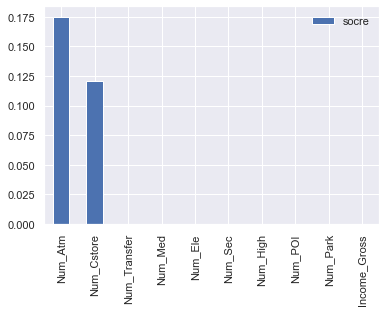

In [8]:
# Lasso模型
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

model = Lasso(max_iter=10**4)
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# 訓練資料Cross Validation
print('Train data:\n')
lasso_scores = cross_val_score(model, X_train, y_train,
         scoring='r2',cv=5 )
# Lasso_scores = np.sqrt(-scores)

display_scores(lasso_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')

r2 = r2_score(y_test, y_pred)
print(f'R^2_test : {r2:.3f}' )

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE_test : {rmse:.3f}') 

# 檢視特徵重要性
feature_score = model.coef_
feature_import(feature_score)

### RandomForest

Train data:

Cross Validation Scores:[0.84739212 0.62235096 0.7771987  0.80761852 0.76140523]
Mean_train  :0.763
Std_train  :0.076

--------------------------------------------------
Test data:

R^2_test : 0.471
RMSE_test : 1.111


<AxesSubplot:>

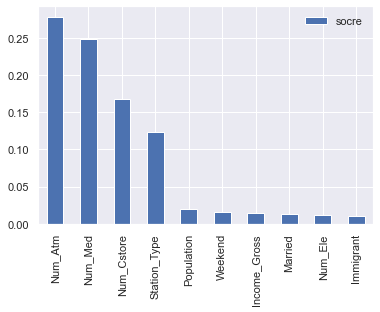

In [9]:
 # 隨機森林迴歸分類器 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  mean_squared_error,r2_score
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# max_depth=5, n_estimators=100
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)


# 訓練資料Cross Validation
print('Train data:\n')
forest_scores = cross_val_score(model, X_train, y_train,
         scoring='r2',cv=5 )
# Lasso_scores = np.sqrt(-scores)

display_scores(forest_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')

r2 = r2_score(y_test, y_pred)
print(f'R^2_test : {r2:.3f}' )

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE_test : {rmse:.3f}') 

# 檢視特徵重要性
feature_score = model.feature_importances_
feature_import(feature_score)

### SVM

In [10]:
# SVM
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error,r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# we can change kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)


# 訓練資料Cross Validation
print('Train data:\n')
svr_scores = cross_val_score(model, X_train, y_train,
         scoring='r2',cv=5 )
# Lasso_scores = np.sqrt(-scores)

display_scores(svr_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')

r2 = r2_score(y_test, y_pred)
print(f'R^2_test : {r2:.3f}' )

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE_test : {rmse:.3f}') 

Train data:

Cross Validation Scores:[0.50390566 0.620056   0.68245064 0.74844177 0.69338165]
Mean_train  :0.650
Std_train  :0.084

--------------------------------------------------
Test data:

R^2_test : 0.614
RMSE_test : 0.949


### GradientBoostingRegressor

Train data:

Cross Validation Scores:[0.80230108 0.69441283 0.73579438 0.84941365 0.75816638]
Mean_train  :0.768
Std_train  :0.054

--------------------------------------------------
Test data:

R^2_test : 0.585
RMSE_test : 0.984


<AxesSubplot:>

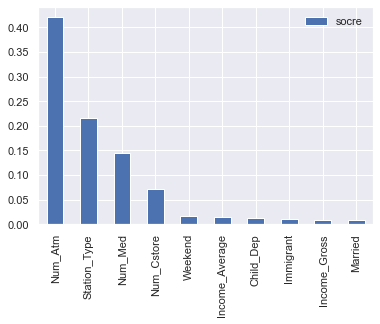

In [11]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error,r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# 訓練資料Cross Validation
print('Train data:\n')
gbrt_scores = cross_val_score(model, X_train, y_train,
         scoring='r2',cv=5 )
# Lasso_scores = np.sqrt(-scores)

display_scores(gbrt_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')

r2 = r2_score(y_test, y_pred)
print(f'R^2_test : {r2:.3f}' )

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE_test : {rmse:.3f}') 

# 檢視特徵重要性
feature_score = model.feature_importances_
feature_import(feature_score)

### 作圖比較各模型在Cross Validation後的rmse得分均值與標準差

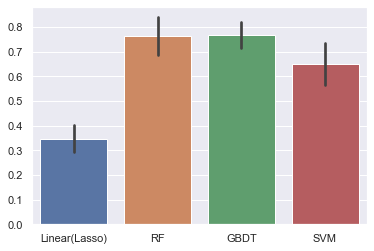

In [12]:
# sns.barplot( ci="sd")
# sns.barplot(x="day", y="tip", data=tips, estimator=median)
from numpy import median,mean
# sns.set_theme(style="whitegrid")

data = {'Linear(Lasso)' :lasso_scores,
        'RF' :forest_scores,
        'GBDT':gbrt_scores,
        'SVM' :svr_scores }

df_CV =pd.DataFrame(data)

ax = sns.barplot(data=df_CV, estimator=mean, ci="sd",   )
# y ='RMSE_Score'


### 微調模型
- 隨機搜尋

#### 以隨機搜尋尋找最佳參數

0.16489128377025372 {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 16}
0.646331212840942 {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 20}
0.6235832149450079 {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 11}
0.3242970773138695 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.5747442583089524 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 19}
0.19711119781581016 {'learning_rate': 0.01, 'loss': 'lad', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 29}
0.7051497768440308 {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 16}
0.7008700504011706 {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 13}
0.6702975694371617 {'learning_rate': 0.1, 'loss': 'lad

<AxesSubplot:>

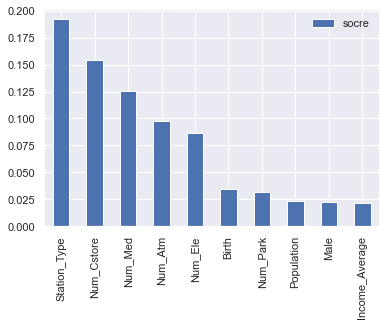

In [13]:
# GradientBoostingRegressor¶
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import  mean_squared_error,r2_score
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

param_distribs = {
    'loss' : ['ls', 'lad', 'huber'],
    'learning_rate': [0.1,0.05,0.01],
    'n_estimators': randint(low=10, high=10*3),
    'max_features': ['log2', 'sqrt'],
    'max_depth': randint(low=1, high=10)
     }

gbdt_reg = GradientBoostingRegressor(random_state = 42)
rnd_search = RandomizedSearchCV(gbdt_reg, param_distributions=param_distribs,
                                n_iter=30, cv=10, scoring='r2',n_jobs=-1 , random_state=42)
 
rnd_search.fit(X_train, y_train)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

# 檢視最佳參數
print(rnd_search.best_estimator_)

# 檢視特徵重要性
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_score = feature_importances
feature_import(feature_score)

In [14]:
# 產出最佳模型
final_model = rnd_search.best_estimator_
X_test = scaler.transform(X_test)
y_pred = final_model.predict(X_test)


# 測試資料績效評估
print('Test data:\n')

r2 = r2_score(y_test, y_pred)
print(f'R^2_test : {r2:.3f}' )

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE_test : {rmse:.3f}') 

Test data:

R^2_test : 0.691
RMSE_test : 0.849


### Model persistence using joblib

In [15]:
# my_model = final_model
# import joblib
# joblib.dump(my_model, "vol_model_reg.pkl") # DIFF
# #...
# my_model_loaded = joblib.load("vol_model_reg.pkl") # DIFF

### 繪製學習曲線

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator = final_model, X=X, y=y, 
    train_sizes= [10, 50, 100, 130], 
    scoring='r2', cv=5, n_jobs=-1)

print('Training sizes:',train_sizes, '\n') 
print('Training scores:\n ',train_scores, '\n')
print('\nTest scores:\n',test_scores, '\n')
print( '-' * 70)

train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1 )
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(test_scores_mean, index = train_sizes))

Training sizes: [ 10  50 100 130] 

Training scores:
  [[0.98521912 0.98521912 0.98521912 0.98521912 0.98521912]
 [0.98482969 0.98465318 0.98469966 0.98469966 0.98469966]
 [0.98385416 0.98325174 0.98302646 0.9826409  0.9826409 ]
 [0.98371804 0.98338971 0.98352943 0.98237772 0.97989512]] 


Test scores:
 [[ 0.05018615 -0.24464546 -0.15344956 -3.05747087 -1.83811583]
 [ 0.40325151  0.17640575  0.25332082 -1.91684864 -1.04730259]
 [-0.38791534 -0.05515112  0.20456611 -2.08039897 -1.24195275]
 [-0.46898488 -0.30905277  0.01898905 -0.62226495 -0.12511034]] 

----------------------------------------------------------------------
Mean training scores

 10     0.985219
50     0.984716
100    0.983083
130    0.982582
dtype: float64

 --------------------

Mean validation scores

 10    -1.048699
50    -0.426235
100   -0.712170
130   -0.301285
dtype: float64


(0.0, 1.1)

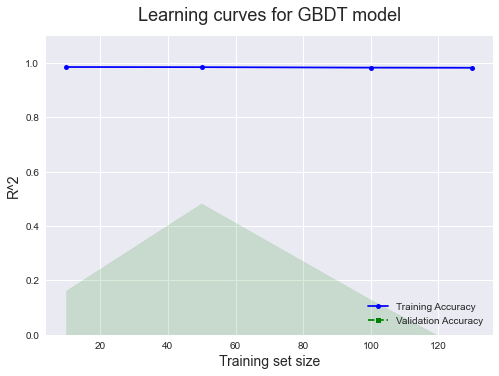

In [17]:
import matplotlib.pyplot as plt

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('seaborn')

plt.plot(train_sizes, train_mean, color='blue' ,marker='o' ,markersize=5, label = 'Training Accuracy')
plt.fill_between(train_sizes,
                train_mean+train_std,
                train_mean-train_std,
                alpha=0.15,color='blue'
                )
plt.plot(train_sizes, test_mean, color='green' ,marker='s' ,markersize=5, linestyle='--',  label = 'Validation Accuracy')

plt.fill_between(train_sizes,
                test_mean+test_std,
                test_mean-test_std,
                alpha=0.15,color='green' 
                )

plt.ylabel('R^2', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for GBDT model', fontsize = 18, y = 1.03)
plt.legend(loc='lower right')
plt.ylim(0,1.1)

## 用訓練出的模型取出預測值

### 取出測試資料預測的y值

In [18]:
# 取出預測的y值， 注意這邊取得的預測值是最後跑的那個model
import math

y_pred = pd.DataFrame( y_pred.reshape(-1,1).round(3), index=y_test.index, columns=['Prediction'])

dataset = [df['Station_Name'], pd.DataFrame((math.e)**y_test/1000), (math.e)**y_pred/1000 ] 

df_y_pred = pd.concat(dataset, join='inner' , axis=1)

# df_y_pred['P_Store'] = (df_y_pred['Prediction'] - df_y_pred[y.name]) 
# df_y_pred['Potential'] = (df_y_pred['Prediction'] - df_y_pred[y.name])/df_y_pred['Prediction']*100

df_y_pred 

,Station_Name,Vol_All,Prediction
9,龍山寺站,62.600,34.132319
12,國父紀念館站,46.164,57.239529
15,後山埤站,33.295,39.616461
16,昆陽站,26.818,24.294372
18,動物園站,17.292,2.296175
19,木柵站,8.426,5.773305
24,六張犁站,22.573,37.086192
29,松山機場站,11.004,13.042910
30,大直站,18.685,23.295139
31,劍南路站,24.184,16.680573


In [19]:
df_y_pred.describe()

,Vol_All,Prediction
count,35.000000,35.000000
mean,23.372457,22.032259
std,18.813581,16.972338
min,0.058000,0.163041
25%,6.715000,8.741967
50%,22.573000,19.072447
75%,34.616500,31.349553
max,69.464000,65.055758


### 將模型套用在未營運的站點 取得預測值

In [20]:
from sklearn import preprocessing
import math


def get_pred_data():

    df  = pd.read_csv( path+file ,encoding='utf-8')
    #     填補缺值
    mask = df['Activated']==1
    mean_Weekend = df.loc[ mask , 'Weekend'].mean()
    df['Weekend'].fillna(mean_Weekend)
    
    model = final_model
    
    X = df[feature_selected]

    # 採用label encoder 將類別資料轉為數值型態
    label_encoder = preprocessing.LabelEncoder()
    encoded_S_Type = label_encoder.fit_transform(X['Station_Type'])
    X.loc[:,'Station_Type'] = encoded_S_Type.copy()

    #正規化
    X = scaler.transform(X)

    # 設定要使用的模型， 注意這邊使用的model是最後跑的那個
    y = (math.e)**model.predict(X)/1000
    y = pd.DataFrame(y.reshape(-1,1), index=df.index, columns=['Vol_All_Pre'])  #取整數

    dataset = [df, y ] 

    df_pred = pd.concat(dataset, join='inner' , axis=1)
    
    #     將轉乘數量從LOG(base=e)轉換回去
    df_pred['Num_Transfer'] = (math.e)**(df_pred['Num_Transfer'])
        
    return df_pred

get_pred_data()

C:\Users\Student\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Station_Type,Activated,Station_ID,Station_Name,T_Status,Num_Transfer,Num_Atm,Num_Cstore,Num_Med,Num_Ele,...,Num_Gym,Num_Lodging,Cat_Vol,Cat_Rent,Cat_Cafe,Cat_Drink,Cat_Bar,Cat_Gym,Cat_Lodging,Vol_All_Pre
0,TpMrt,1,BL01,頂埔站,N,1.0,13,6,6,5,...,3.0,0.0,6.0,2,0,0,0,0,0,14.900803
1,TpMrt,1,BL02,永寧站,N,1.0,11,5,1,9,...,0.0,0.0,7.0,1,0,0,0,0,0,23.040552
2,TpMrt,1,BL03,土城站,N,1.0,22,10,28,7,...,4.0,1.0,6.0,2,0,0,0,1,0,14.477068
3,TpMrt,1,BL04,海山站,N,1.0,40,22,41,26,...,6.0,0.0,7.0,2,0,0,0,1,0,33.903331
4,TpMrt,1,BL05,亞東醫院站,N,1.0,19,8,9,18,...,1.0,0.0,8.0,1,0,0,0,0,0,33.641540
5,TpMrt,1,BL06,府中站,N,1.0,50,23,80,36,...,13.0,2.0,8.0,2,2,1,2,3,0,45.544852
6,TpMrt_Train_Thsr,1,BL07_Y16_1020_Banqiao,板橋站,MTH,4.0,42,21,35,36,...,18.0,4.0,9.0,3,3,1,1,5,0,86.110508
7,TpMrt,1,BL08,新埔站,N,1.0,48,31,86,55,...,16.0,2.0,8.0,3,4,0,1,4,0,54.606709
8,TpMrt,1,BL09,江子翠站,N,1.0,43,19,56,42,...,9.0,0.0,8.0,2,2,0,1,2,0,42.814376
9,TpMrt,1,BL10,龍山寺站,N,1.0,40,18,32,32,...,7.0,13.0,8.0,2,2,0,1,2,2,34.144369


In [21]:
import sys,os,time

# Where to save the data
PROJECT_ROOT_DIR = "../"
dir_name = "prediction_result/"
DATA_PATH = os.path.join(PROJECT_ROOT_DIR,dir_name)
os.makedirs(DATA_PATH, exist_ok=True)

def save_data(file_name):
    df = get_pred_data().copy()
    df.to_csv( DATA_PATH + file_name ,encoding='utf-8')
    print("Saving DATA:", file_name)

time =time.strftime("%y%m%d_%H%M")
save_data(f'Vol_All_Pre_{time}.csv')



Saving DATA: Vol_All_Pre_210122_1120.csv


C:\Users\Student\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
df_pred = get_pred_data()
df_pred.loc[df['Activated']==1,['Vol_All','Vol_All_Pre']].describe()

C:\Users\Student\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Vol_All,Vol_All_Pre
count,173.000000,173.000000
mean,29.551497,22.895598
std,41.130682,24.262761
min,0.018000,0.038806
25%,4.698000,4.236491
50%,19.011000,17.477345
75%,44.154000,33.903331
max,315.115000,181.365853


<AxesSubplot:ylabel='Frequency'>

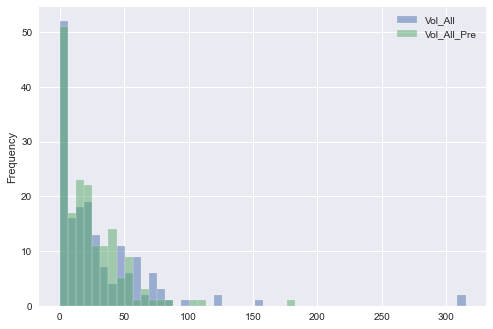

In [23]:
df_pred.loc[df['Activated']==1,['Vol_All','Vol_All_Pre']].plot.hist(alpha=0.5,bins=50)